In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
from scipy.stats import kstest
from scipy.special import softmax
import torch
import powerlaw
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


In [3]:
# read .npz files from data folder


# read adj matrix
data_path = './data/NYCBike1/'

# check the files in the folder
files = os.listdir(data_path)

for file in files:
    print(file)

adj_mx.npz
test.npz
train.npz
val.npz


In [4]:
adj_mx = np.load(data_path + 'adj_mx.npz')
print("Adj. matrix files: ", adj_mx.files)
test = np.load(data_path + 'test.npz')
print("Test  files: ", test.files)
train = np.load(data_path + 'train.npz')
print("Train files: ", train.files)
val = np.load(data_path + 'val.npz')
print("Values files:", val.files)

Adj. matrix files:  ['adj_mx']
Test  files:  ['x', 'y', 'x_offsets', 'y_offsets']
Train files:  ['x', 'y', 'x_offsets', 'y_offsets']
Values files: ['x', 'y', 'x_offsets', 'y_offsets']


In [5]:
adj_mx = adj_mx['adj_mx']

# Test  files:  ['x', 'y', 'x_offsets', 'y_offsets'] save in one file
test_x = test['x']
test_y = test['y']
test_x_offsets = test['x_offsets']
test_y_offsets = test['y_offsets']

# Train files:  ['x', 'y', 'x_offsets', 'y_offsets'] save in one file
train_x = train['x']
train_y = train['y']
train_x_offsets = train['x_offsets']
train_y_offsets = train['y_offsets']

# Values files: ['x', 'y', 'x_offsets', 'y_offsets'] save in one file
val_x = val['x']
val_y = val['y']
val_x_offsets = val['x_offsets']
val_y_offsets = val['y_offsets']




In [6]:
test_x.shape, test_y.shape, test_x_offsets.shape, test_y_offsets.shape

((864, 19, 128, 2), (864, 1, 128, 2), (19, 1), (1, 1))

In [7]:
test_x_offsets

array([[-73],
       [-72],
       [-71],
       [-70],
       [-69],
       [-49],
       [-48],
       [-47],
       [-46],
       [-45],
       [-25],
       [-24],
       [-23],
       [-22],
       [-21],
       [ -3],
       [ -2],
       [ -1],
       [  0]], dtype=int64)

In [8]:
import numpy as np

path_topology = './aug_graphs_topology/'
path_traffic = './aug_graphs_traffic/'

# read topology graphs and traffic graphs from .npy files
# topology graphs aug_graph_x.npy
# traffic graphs aug_graph_y.npy


aug_graphs_topology = []

for i in range(1, 107):
    aug_graphs_topology.append(np.load(path_topology + 'aug_graph_' + str(i) + '.npy'))

aug_graphs_traffic = []

for i in range(1, 107):
    aug_graphs_traffic.append(np.load(path_traffic + 'aug_flow_' + str(i) + '.npy'))

In [9]:
adj_matrix = aug_graphs_topology[75]

In [10]:
G = nx.from_numpy_array(adj_matrix)

In [11]:

all_pair_distances = nx.floyd_warshall(G)
mean_distance = sum([dist for node_distances in all_pair_distances.values() for dist in node_distances.values()]) / (len(G) * (len(G) - 1))
average_clustering_coefficient = nx.average_clustering(G)

In [12]:
mean_distance
average_clustering_coefficient


0.4493737599206355

In [13]:
observed_edges = len(G.edges())
possible_edges = len(G.nodes()) * (len(G.nodes()) - 1) / 2  # For an undirected graph
p = observed_edges / possible_edges
p

0.054010826771653545

In [14]:
num_ensemble = 20
mean_distances = []
mean_clustering_coefficients = []

for i in range(num_ensemble):
    
    # Create ER graph
    er_graph = nx.erdos_renyi_graph(len(G.nodes()), p)

    all_distances = nx.floyd_warshall(er_graph)
    

    # Step 3: Calculate mean distance for each ER graph
    er_mean_distance = sum([dist for node_distances in all_distances.values() for dist in node_distances.values()]) / (len(er_graph) * (len(er_graph) - 1))
    
    mean_clustering_coefficients.append(nx.average_clustering(er_graph))
    mean_distances.append(er_mean_distance if er_mean_distance != float('inf') else np.mean(mean_distances))
    
# Step 4: Calculate the mean of mean distances
print(i, ',', mean_distances[i], ',', mean_clustering_coefficients[i])
ensemble_mean_distance = np.mean(mean_distances)
ensemble_mean_clustering_coefficient = np.mean(mean_clustering_coefficients)


19 , 2.706200787401575 , 0.03984626484626482


In [15]:
print('L / L_r =',  mean_distance/ensemble_mean_distance)
print('C / C_r =', average_clustering_coefficient/ensemble_mean_clustering_coefficient )


L / L_r = 1.4684804942163743
C / C_r = 8.172064975835827


Sparsity Index (equal to observed edges/ possible edges)

In [16]:
import networkx as nx
import numpy as np
from scipy.stats import powerlaw, kstest
import matplotlib.pyplot as plt

# Assuming you have a graph G
# G = ...

# Calculate degree distribution
degree_sequence = [d for n, d in G.degree()]

# Plot the degree distribution
plt.hist(degree_sequence, bins='auto', alpha=0.75, density=True, edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

# Fit the data to a power-law distribution
fit_alpha, fit_loc, fit_beta = powerlaw.fit(degree_sequence)

# Plot the power-law fit
x_range = np.linspace(0, 1000, num=1000)
pdf = powerlaw.pdf(x_range, fit_alpha, fit_loc, fit_beta)
plt.plot(x_range, pdf, 'r-', linewidth=2, label='Fit')

# Perform Kolmogorov-Smirnov test
ks_statistic, ks_p_value = kstest(degree_sequence, 'powerlaw', args=(fit_alpha, fit_loc, fit_beta))
print("K-S Statistic:", ks_statistic)
print("P-value:", ks_p_value)




: 

In [ ]:
ks_p_value

6.209077754752911e-24

In [ ]:
def rewire_to_small_world(G,sim, p, only_distance = False):
    n = len(G.nodes())
    
    degree_sequence = [d for n, d in G.degree()]
    
    if not only_distance:
    # Ensure the matrix is symmetric


        # Iterate through each edge
        for i in range(n):
            for j in range(i + 1, n):
                # Check if there is an edge
                if G.has_edge(i,j):
                    # Rewire the edge with probability p
                    if np.random.rand() < p:
                        
                        # Choose a random node (excluding the source node and its neighbors)
                        choices = np.delete(np.arange(n), [i, *np.where(nx.to_numpy_array(G)[i, :] == 1)[0]])
                        new_j = np.random.choice(choices)

                        # Rewire the edge
                        if G.degree(new_j < np.mean(degree_sequence)) & G.degree(j > np.mean(degree_sequence)):
                            G.remove_edge(i,j)
                            G.add_edge(i, new_j)

    else:
        probability_of_edge = p 

# Randomly add edges based on the specified probability
        for node1 in range(n):
            for node2 in range(node1 + 1, n):
                if (random.random() < probability_of_edge) & (sim[node1,node2] < 0.9) & G.has_edge(node1,node2) & G.degree(node1) != np.min(G.degree()) & G.degree(node2)!= np.min(G.degree()):
            # Set both entries to 1 to represent an undirected graph
                   G.remove_edge(node1, node2)
    
    return G

# Example usage
n = 20  # Number of nodes
p = 0.3  # Rewiring probability

In [ ]:
adj2 = adj_matrix

In [ ]:
G2 = nx.from_numpy_array(adj2)



In [ ]:
def generate_power_law_graph(G, similarity_matrix, alpha):
    # Create a graph from the adjacency matrix
    

    # Get the number of nodes in the graph
    num_nodes = G.number_of_nodes()

    # Add edges based on power-law distribution and node similarities
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if (((G.degree(j)))/np.sum(list(dict(G.degree()).values()))>0.01) :
                G.add_edge(i, j)

    return G

Random similarity matrix


In [ ]:
n = 128

# Generate a random float matrix with values between 0 and 1
random_float_array = np.random.rand(n, n)


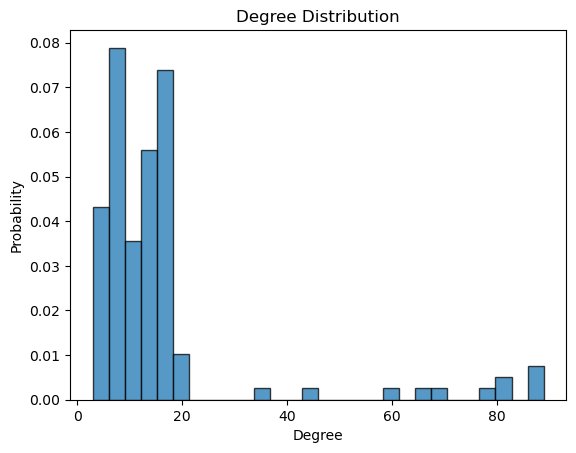

In [ ]:
alpha = 4 # Power-law exponent

# Generate the power-law distributed graph
power_law_graph = generate_power_law_graph(G, random_float_array, alpha)

# Visualize the graph
degree_sequence = [d for n, d in power_law_graph.degree()]

# Plot the degree distribution
plt.hist(degree_sequence, bins='auto', alpha=0.75, density=True, edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()


In [ ]:
observed_edges = len(power_law_graph.edges())
possible_edges = len(power_law_graph.nodes()) * (len(power_law_graph.nodes()) - 1) / 2  # For an undirected graph
p = observed_edges / possible_edges
p

0.13176673228346455

In [ ]:
num_ensemble = 20
mean_distances = []
mean_clustering_coefficients = []

for i in range(num_ensemble):
    
    # Create ER graph
    er_graph = nx.erdos_renyi_graph(len(G.nodes()), p)

    all_distances = nx.floyd_warshall(er_graph)
    

    # Step 3: Calculate mean distance for each ER graph
    er_mean_distance = sum([dist for node_distances in all_distances.values() for dist in node_distances.values()]) / (len(er_graph) * (len(er_graph) - 1))
    
    mean_clustering_coefficients.append(nx.average_clustering(er_graph))
    mean_distances.append(er_mean_distance if er_mean_distance != float('inf') else np.mean(mean_distances))
    print(i, ',', mean_distances[i], ',', mean_clustering_coefficients[i])
# Step 4: Calculate the mean of mean distances
ensemble_mean_distance = np.mean(mean_distances)
ensemble_mean_clustering_coefficient = np.mean(mean_clustering_coefficients)

0 , 1.9772391732283465 , 0.12486568835811972
1 , 1.9579232283464567 , 0.1267428259821141
2 , 1.9480807086614174 , 0.13126059889279826
3 , 1.9459891732283465 , 0.13304420761792526
4 , 1.954601377952756 , 0.128802324406213
5 , 1.9699803149606299 , 0.13230035418093072
6 , 1.9753937007874016 , 0.12943056147832713
7 , 1.9569389763779528 , 0.12740882297481113
8 , 1.9576771653543308 , 0.14033828821824967
9 , 1.9640748031496063 , 0.13323712430396845
10 , 1.984005905511811 , 0.13245463512537112
11 , 1.9638287401574803 , 0.12530754521146367
12 , 1.9475885826771653 , 0.1352216538386708
13 , 1.9616141732283465 , 0.12858350875576957
14 , 1.967273622047244 , 0.13379601718825526
15 , 1.924458661417323 , 0.1384330710384277
16 , 1.9562007874015748 , 0.13647410855865866
17 , 1.9469734251968505 , 0.13798652387538105
18 , 1.953494094488189 , 0.131238896240312
19 , 1.9701033464566928 , 0.11998528202568631


In [ ]:


all_pair_distances = nx.floyd_warshall(power_law_graph)
mean_distance = sum([dist for node_distances in all_pair_distances.values() for dist in node_distances.values()]) / (len(power_law_graph) * (len(power_law_graph) - 1))
average_clustering_coefficient = nx.average_clustering(power_law_graph)

In [ ]:
print('L / L_r =',  mean_distance/ensemble_mean_distance)
print('C / C_r =', average_clustering_coefficient/ensemble_mean_clustering_coefficient )

L / L_r = 1.304057045430996
C / C_r = 5.361255155219941


In [ ]:
power_law_graph = rewire_to_small_world(power_law_graph, random_float_array, 0.05, only_distance= False)
power_law_graph = rewire_to_small_world(power_law_graph, random_float_array, 0.7, only_distance= True)

In [ ]:
observed_edges = len(power_law_graph.edges())
possible_edges = len(power_law_graph.nodes()) * (len(power_law_graph.nodes()) - 1) / 2  # For an undirected graph
p = observed_edges / possible_edges
p

num_ensemble = 20
mean_distances = []
mean_clustering_coefficients = []

for i in range(num_ensemble):
    
    # Create ER graph
    er_graph = nx.erdos_renyi_graph(len(G.nodes()), p)

    all_distances = nx.floyd_warshall(er_graph)
    

    # Step 3: Calculate mean distance for each ER graph
    er_mean_distance = sum([dist for node_distances in all_distances.values() for dist in node_distances.values()]) / (len(er_graph) * (len(er_graph) - 1))
    
    mean_clustering_coefficients.append(nx.average_clustering(er_graph))
    mean_distances.append(er_mean_distance if er_mean_distance != float('inf') else np.mean(mean_distances))
    print(i, ',', mean_distances[i], ',', mean_clustering_coefficients[i])
# Step 4: Calculate the mean of mean distances
ensemble_mean_distance = np.mean(mean_distances)
ensemble_mean_clustering_coefficient = np.mean(mean_clustering_coefficients)

0 , 1.9726870078740157 , 0.13403816544411581
1 , 1.9486958661417322 , 0.1305843151750764
2 , 1.970349409448819 , 0.12984350832829444
3 , 1.9606299212598426 , 0.13593666949408587
4 , 1.9575541338582678 , 0.13671915211264274
5 , 1.9762549212598426 , 0.12593516921326953
6 , 1.9632135826771653 , 0.12514031677716106
7 , 1.9558316929133859 , 0.13601215015998577
8 , 1.969365157480315 , 0.13710765035019537
9 , 1.953986220472441 , 0.13546115194295555
10 , 1.96875 , 0.13080868013380162
11 , 1.9302411417322836 , 0.14534249661934973
12 , 1.9403297244094488 , 0.13390862563640368
13 , 1.9778543307086613 , 0.11880927245505135
14 , 1.9421751968503937 , 0.1391769624053999
15 , 1.9569389763779528 , 0.14226417127953747
16 , 1.9591535433070866 , 0.13520618175911195
17 , 1.9789616141732282 , 0.129816435449291
18 , 1.954601377952756 , 0.1363060782966409
19 , 1.9733021653543308 , 0.13568779427988786


In [ ]:
print('L / L_r =',  mean_distance/ensemble_mean_distance)
print('C / C_r =', average_clustering_coefficient/ensemble_mean_clustering_coefficient )

L / L_r = 1.303144590939612
C / C_r = 5.26663911289178


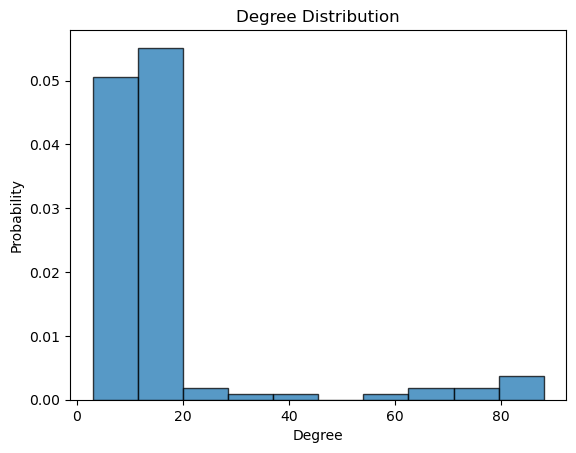

In [ ]:
degree_sequence = [d for n, d in power_law_graph.degree()]

# Plot the degree distribution
plt.hist(degree_sequence,  alpha=0.75, density=True, edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

In [ ]:
power_law_graph.degree()

DegreeView({0: 14, 1: 16, 2: 16, 3: 15, 4: 15, 5: 16, 6: 16, 7: 17, 8: 16, 9: 21, 10: 20, 11: 16, 12: 19, 13: 16, 14: 18, 15: 16, 16: 15, 17: 18, 18: 18, 19: 18, 20: 19, 21: 18, 22: 36, 23: 14, 24: 14, 25: 16, 26: 18, 27: 18, 28: 17, 29: 17, 30: 43, 31: 14, 32: 13, 33: 15, 34: 16, 35: 14, 36: 17, 37: 16, 38: 17, 39: 14, 40: 13, 41: 17, 42: 17, 43: 15, 44: 17, 45: 17, 46: 16, 47: 12, 48: 60, 49: 13, 50: 12, 51: 15, 52: 16, 53: 16, 54: 16, 55: 12, 56: 12, 57: 67, 58: 68, 59: 14, 60: 13, 61: 12, 62: 11, 63: 10, 64: 12, 65: 14, 66: 13, 67: 12, 68: 11, 69: 77, 70: 13, 71: 9, 72: 9, 73: 11, 74: 10, 75: 77, 76: 81, 77: 9, 78: 11, 79: 8, 80: 8, 81: 85, 82: 9, 83: 87, 84: 88, 85: 8, 86: 9, 87: 5, 88: 5, 89: 8, 90: 8, 91: 8, 92: 8, 93: 8, 94: 8, 95: 5, 96: 5, 97: 8, 98: 9, 99: 8, 100: 8, 101: 8, 102: 8, 103: 5, 104: 5, 105: 8, 106: 8, 107: 8, 108: 9, 109: 8, 110: 8, 111: 5, 112: 6, 113: 8, 114: 8, 115: 8, 116: 8, 117: 8, 118: 8, 119: 5, 120: 3, 121: 5, 122: 6, 123: 6, 124: 5, 125: 5, 126: 5, 127

In [ ]:
fit_alpha, fit_loc, fit_beta = powerlaw.fit(degree_sequence)

# Plot the power-law fit
x_range = np.linspace(min(degree_sequence), max(degree_sequence), num=10)
pdf = powerlaw.pdf(x_range, fit_alpha, fit_loc, fit_beta)


# Perform Kolmogorov-Smirnov test
ks_statistic, ks_p_value = kstest(degree_sequence, 'powerlaw', args=(2,2,2))
print("K-S Statistic:", ks_statistic)
print("P-value:", ks_p_value)


K-S Statistic: 0.984375
P-value: 1.2882297539194267e-231


In [ ]:
x = nx.to_numpy_array(G)

NameError: name 'G' is not defined

In [ ]:
y = torch.from_numpy(x)

NameError: name 'x' is not defined